In [3]:
import nltk
nltk.download('all')
from nltk.corpus import stopwords

from nltk.tokenize import word_tokenize

from nltk.stem import WordNetLemmatizer

import matplotlib.pyplot as plt
import re
import numpy as np

# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

# spacy for lemmatization
import spacy

# Plotting tools
import pyLDAvis
import pyLDAvis.gensim  # don't skip this
import matplotlib.pyplot as plt
%matplotlib inline

# Enable logging for gensim - optional
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

[nltk_data] Downloading collection 'all'
[nltk_data]    | 
[nltk_data]    | Downloading package abc to /root/nltk_data...
[nltk_data]    |   Package abc is already up-to-date!
[nltk_data]    | Downloading package alpino to /root/nltk_data...
[nltk_data]    |   Package alpino is already up-to-date!
[nltk_data]    | Downloading package averaged_perceptron_tagger to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Package averaged_perceptron_tagger is already up-
[nltk_data]    |       to-date!
[nltk_data]    | Downloading package averaged_perceptron_tagger_ru to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Package averaged_perceptron_tagger_ru is already
[nltk_data]    |       up-to-date!
[nltk_data]    | Downloading package basque_grammars to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Package basque_grammars is already up-to-date!
[nltk_data]    | Downloading package bcp47 to /root/nltk_data...
[nltk_data]    |   Package bcp47 is already up-to-dat

In [2]:
!pip install pyLDAvis

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.6/2.6 MB 12.1 MB/s eta 0:00:00


In [40]:
import pandas as pd
data = pd.read_csv('/content/sample_data/sam_scrap_facebook.csv')
print(data)

                                               Content Reactions     Comments  \
0    H here!i became a full-time housesitter as of ...        66  21 comments   
1    We’ve put together a timeline of our experienc...        43   4 comments   
2    Hello to our Yellowknife clients. We have rece...         6   5 comments   
3    *Please note due to evacuation orders to both ...         2          NaN   
4    As wildfires continue to spread, we are seeing...        38  14 comments   
..                                                 ...       ...          ...   
945  Yellowknife Canada City empties as thousands f...       1.0    1 comment   
946  https://thewesterner.blogspot.com/.../wildfire...       1.0          NaN   
947  Cool! You can buy a fire? Seems it comes with ...       9.0   3 comments   
948  The City of Yellowknife and a nearby First Nat...     341.0          NaN   
949  The last two weeks have been stressful, emotio...       NaN          NaN   

         Reposts           

In [41]:
data = data.drop(columns=['Location'])

In [42]:
print(data['Reactions'].isna().sum())
print(data['Comments'].isna().sum())
print(data['Reposts'].isna().sum())

141
398
398


In [43]:
data['Reactions'].fillna(0)
data['Comments'].fillna(0)
data['Reposts'].fillna(0)

0      21 comments
1       4 comments
2       5 comments
3                0
4      14 comments
          ...     
945      1 comment
946              0
947     3 comments
948              0
949              0
Name: Reposts, Length: 950, dtype: object

In [44]:
import re

# Remove special characters from the 'Text' column
data['Content'] = data['Content'].apply(lambda x: re.sub(r'[^a-zA-Z\s]', '', x))

# Print the updated DataFrame
print(data['Content'])

0      H herei became a fulltime housesitter as of au...
1      Weve put together a timeline of our experience...
2      Hello to our Yellowknife clients We have recei...
3      Please note due to evacuation orders to both Y...
4      As wildfires continue to spread we are seeing ...
                             ...                        
945    Yellowknife Canada City empties as thousands f...
946         httpsthewesternerblogspotcomwildfiretriggers
947    Cool You can buy a fire Seems it comes with he...
948    The City of Yellowknife and a nearby First Nat...
949    The last two weeks have been stressful emotion...
Name: Content, Length: 950, dtype: object


In [45]:
def preprocess_text(text):

    # Tokenize the text

    tokens = word_tokenize(text.lower())




    # Remove stop words

    filtered_tokens = [token for token in tokens if token not in stopwords.words('english')]




    # Lemmatize the tokens

    lemmatizer = WordNetLemmatizer()

    lemmatized_tokens = [lemmatizer.lemmatize(token) for token in filtered_tokens]




    # Join the tokens back into a string

    processed_text = ' '.join(lemmatized_tokens)

    return processed_text

In [46]:
data['Content'] = data['Content'].apply(preprocess_text)
data['Content'] = data['Content'].apply(lambda x: re.sub(r'[^a-zA-Z\s]', '', x))
corpus = [i for i in data['Content']]
print(corpus)

['h herei became fulltime housesitter august st evacuation taking lot time im looking continue long possible current availability see', 'weve put together timeline experience evacuation wanted share publicly know others shared concern unhoused community member here critical moment timeline find full detail website httpswwwykwscapostykwsevacuationstory', 'hello yellowknife client received updated information insurer mass evacuation coverage sits additional living expense available personal line policy holder coverage available differs insurance company insurance company therefore situation may differ family friend ask contact claim department insurance company directly speed establishing claim f see', 'please note due evacuation order yellowknife hay river office still closedhay river client please contactmarknorlandinsurancecom hollynorlandinsurancecomor see', 'wildfire continue spread seeing influx displaced wildlife entering city search safety stay safe stay vigilant keep eye furry f

In [47]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.decomposition import LatentDirichletAllocation as LDA
from nltk.corpus import stopwords

In [48]:
count_vect = CountVectorizer(stop_words=stopwords.words('english'), lowercase=True)
x_counts = count_vect.fit_transform(corpus)
x_counts.todense()
print(count_vect.get_feature_names_out())

['aaron' 'aaronykmotorscom' 'ab' ... 'zucchini' 'zuckerberg' 'zulu']


In [49]:
tfidf_transformer = TfidfTransformer()
x_tfidf = tfidf_transformer.fit_transform(x_counts)

In [50]:
dimension = 5
lda = LDA(n_components = dimension)
lda_array = lda.fit_transform(x_tfidf)
print(lda_array)

[[0.84016394 0.03992578 0.03981495 0.04016948 0.03992584]
 [0.04181971 0.03655659 0.03678528 0.03780215 0.84703626]
 [0.03249446 0.03210501 0.03340417 0.87020882 0.03178755]
 ...
 [0.53079406 0.35591167 0.03767835 0.03782501 0.03779091]
 [0.82281206 0.04408005 0.04443001 0.04475938 0.0439185 ]
 [0.04556838 0.04494616 0.04498317 0.81972201 0.04478028]]


In [51]:
components = [lda.components_[i] for i in range(len(lda.components_))]
features = count_vect.get_feature_names_out()
important_words = [sorted(features, key = lambda x: components[j][np.where(features == x)[0][0]], reverse = True)[:3] for j in range(len(components))]
print(important_words)

[['yellowknife', 'wildfire', 'evacuation'], ['yellowknife', 'wildfire', 'nwt'], ['yellowknife', 'evacuation', 'wildfire'], ['yellowknife', 'city', 'evacuation'], ['community', 'yellowknife', 'wildfire']]


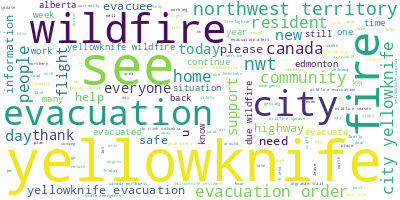

In [52]:
# Import the wordcloud library
from wordcloud import WordCloud
# Join the different processed titles together.
long_string = ','.join(list(data['Content'].values))
# Create a WordCloud object
wordcloud = WordCloud(background_color="white", max_words=5000, contour_width=3, contour_color='steelblue')
# Generate a word cloud
wordcloud.generate(long_string)
# Visualize the word cloud
wordcloud.to_image()

In [57]:
stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'edu', 'use'])
def sent_to_words(sentences):
    for sentence in sentences:
        # deacc=True removes punctuations
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc))
             if word not in stop_words] for doc in texts]

words = data['Content'].values
data_words = list(sent_to_words(words))
# remove stop words
data_words = remove_stopwords(data_words)
print(data_words)

[['herei', 'became', 'fulltime', 'housesitter', 'august', 'st', 'evacuation', 'taking', 'lot', 'time', 'im', 'looking', 'continue', 'long', 'possible', 'current', 'availability', 'see'], ['weve', 'put', 'together', 'timeline', 'experience', 'evacuation', 'wanted', 'share', 'publicly', 'know', 'others', 'shared', 'concern', 'unhoused', 'community', 'member', 'critical', 'moment', 'timeline', 'find', 'full', 'detail', 'website'], ['hello', 'yellowknife', 'client', 'received', 'updated', 'information', 'insurer', 'mass', 'evacuation', 'coverage', 'sits', 'additional', 'living', 'expense', 'available', 'personal', 'line', 'policy', 'holder', 'coverage', 'available', 'differs', 'insurance', 'company', 'insurance', 'company', 'therefore', 'situation', 'may', 'differ', 'family', 'friend', 'ask', 'contact', 'claim', 'department', 'insurance', 'company', 'directly', 'speed', 'establishing', 'claim', 'see'], ['please', 'note', 'due', 'evacuation', 'order', 'yellowknife', 'hay', 'river', 'office'

In [58]:
import gensim.corpora as corpora
# Create Dictionary
id2word = corpora.Dictionary(data_words)
# Create Corpus
texts = data_words
# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]
# View
print(corpus[:1][0][:30])

[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1), (7, 1), (8, 1), (9, 1), (10, 1), (11, 1), (12, 1), (13, 1), (14, 1), (15, 1), (16, 1), (17, 1)]


In [98]:
from pprint import pprint
# number of topics
num_topics = 6
# Build LDA model
lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                       id2word=id2word,
                                       num_topics=num_topics)
# Print the Keyword in the 10 topics
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.044*"yellowknife" + 0.029*"wildfire" + 0.020*"evacuation" + 0.018*"city" '
  '+ 0.013*"see" + 0.010*"fire" + 0.009*"northwest" + 0.008*"territory" + '
  '0.008*"resident" + 0.007*"order"'),
 (1,
  '0.020*"fire" + 0.019*"yellowknife" + 0.017*"wildfire" + 0.016*"see" + '
  '0.014*"evacuation" + 0.010*"update" + 0.009*"city" + 0.007*"canada" + '
  '0.006*"nwt" + 0.006*"territory"'),
 (2,
  '0.025*"yellowknife" + 0.018*"evacuation" + 0.017*"wildfire" + 0.015*"fire" '
  '+ 0.014*"see" + 0.011*"city" + 0.010*"resident" + 0.005*"flight" + '
  '0.005*"order" + 0.005*"canada"'),
 (3,
  '0.036*"yellowknife" + 0.024*"wildfire" + 0.017*"see" + 0.015*"fire" + '
  '0.012*"evacuation" + 0.009*"city" + 0.008*"northwest" + 0.008*"resident" + '
  '0.007*"territory" + 0.007*"nwt"'),
 (4,
  '0.027*"yellowknife" + 0.018*"see" + 0.018*"evacuation" + 0.015*"wildfire" + '
  '0.010*"city" + 0.009*"fire" + 0.007*"northwest" + 0.007*"territory" + '
  '0.005*"canada" + 0.005*"community"'),
 (5,
  '0.028

In [99]:
#The two main inputs to the LDA topic model are the dictionary(id2word) and the corpus. Let's create them.
# Create Dictionary
id2word = corpora.Dictionary(data_words)
print(id2word)


Dictionary<4360 unique tokens: ['august', 'availability', 'became', 'continue', 'current']...>


In [100]:
coherence_model_lda = CoherenceModel(model = lda_model, texts=data_words, dictionary= id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Coherence Score:  0.3806697163424711


In [90]:
def compute_coherence_score(dictionary, corpus, texts, limit, start = 2, step = 1):
  coherence_values = []
  model_list = []
  for num_topics in range(start, limit, step):
    model = gensim.models.ldamodel.LdaModel(corpus=corpus, num_topics=num_topics, random_state=100, chunksize=200, passes=10, per_word_topics=True, id2word=id2word)
    model_list.append(model)
    coherence_model = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
    coherence_values.append(coherence_model.get_coherence())

  return model_list, coherence_values


In [91]:
 model_list, coherence_values = compute_coherence_score(dictionary=id2word, corpus=corpus, texts=data_words, limit=8, start=2, step=1)

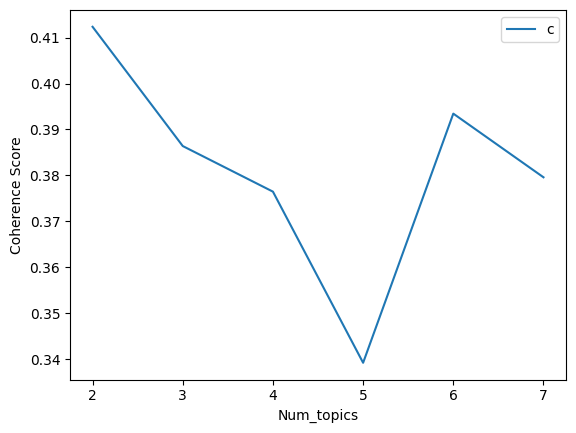

In [74]:
limit=8
start=2
step=1
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num_topics")
plt.ylabel("Coherence Score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [75]:
for m, cv in zip(x, coherence_values):
  print("Num topics = ", m, "has coherence value of", cv)

Num topics =  2 has coherence value of 0.41235772636869505
Num topics =  3 has coherence value of 0.38638610428082143
Num topics =  4 has coherence value of 0.3764566394088501
Num topics =  5 has coherence value of 0.3391927593443488
Num topics =  6 has coherence value of 0.3934475905979959
Num topics =  7 has coherence value of 0.3795843114568212


In [92]:
import pyLDAvis.gensim
import pickle
import pyLDAvis
import os
# Visualize the topics
pyLDAvis.enable_notebook()
LDAvis_data_filepath = os.path.join('./sample_data/results/ldavis_prepared_'+str(num_topics))
# # this is a bit time consuming - make the if statement True
# # if you want to execute visualization prep yourself
if 1 == 1:
    LDAvis_prepared = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)
    with open(LDAvis_data_filepath, 'wb') as f:
        pickle.dump(LDAvis_prepared, f)
# load the pre-prepared pyLDAvis data from disk
with open(LDAvis_data_filepath, 'rb') as f:
    LDAvis_prepared = pickle.load(f)
pyLDAvis.save_html(LDAvis_prepared, './sample_data/results/ldavis_prepared_'+ str(num_topics) +'.html')
LDAvis_prepared

PreparedData(topic_coordinates=              x    y  topics  cluster       Freq
topic                                           
0      0.012173  0.0       1        1  56.120808
1     -0.012173  0.0       2        1  43.879192, topic_info=       Term        Freq       Total Category  logprob  loglift
276      zf   54.000000   54.000000  Default  30.0000  30.0000
163    fire  276.000000  276.000000  Default  29.0000  29.0000
609  update   91.000000   91.000000  Default  28.0000  28.0000
560    lake   39.000000   39.000000  Default  27.0000  27.0000
158  canada  128.000000  128.000000  Default  26.0000  26.0000
..      ...         ...         ...      ...      ...      ...
416     nwt   39.771584  115.471735   Topic2  -5.4812  -0.2421
547    news   27.975165   68.572626   Topic2  -5.8330  -0.0728
193    week   24.320843   58.476823   Topic2  -5.9730  -0.0536
74      due   25.748684   74.151673   Topic2  -5.9159  -0.2340
216     day   23.987928   63.808056   Topic2  -5.9868  -0.1546

[184 rows x 6 columns], token_table=      Topic      Freq        Term
term                             
2902      1  0.208151    activity
2902      2  0.832604    activity
355       1  0.398876         air
355       2  0.598315         air
257       1  0.452774     alberta
...     ...       ...         ...
276       2  0.812634          zf
3720      1  0.416665  zfdistance
3720      2  0.833329  zfdistance
565       1  0.248934       zfthe
565       2  0.746802       zfthe

[265 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 2])

In [96]:
# Wordcloud of Top N words in each topic
import wordcloud
from matplotlib import pyplot as plt
from wordcloud import WordCloud, STOPWORDS
import matplotlib.colors as mcolors
cols = [color for name, color in mcolors. TABLEAU_COLORS. items()] # more colors: 'mcolors.XKCD_COLORS'
cloud = WordCloud(stopwords=stop_words, background_color='white', width=2500, height=2800, max_words=15, colormap='tab10', color_func=lambda *args, **kwargs: cols[i], prefer_horizontal=1.0)
topics = lda_model.show_topics(formatted=False)
print(topics)

[(0, [('yellowknife', 0.031839162), ('wildfire', 0.022942197), ('evacuation', 0.017843617), ('see', 0.016443914), ('city', 0.011258513), ('fire', 0.010127796), ('resident', 0.0064518987), ('nwt', 0.006197466), ('territory', 0.0060030962), ('northwest', 0.005412531)]), (1, [('yellowknife', 0.030702978), ('wildfire', 0.019479554), ('evacuation', 0.01749912), ('fire', 0.016027601), ('see', 0.014517844), ('city', 0.012793432), ('territory', 0.00691133), ('canada', 0.0068949424), ('northwest', 0.006519275), ('resident', 0.0064859972)])]


<function show at 0x797f01229c60>

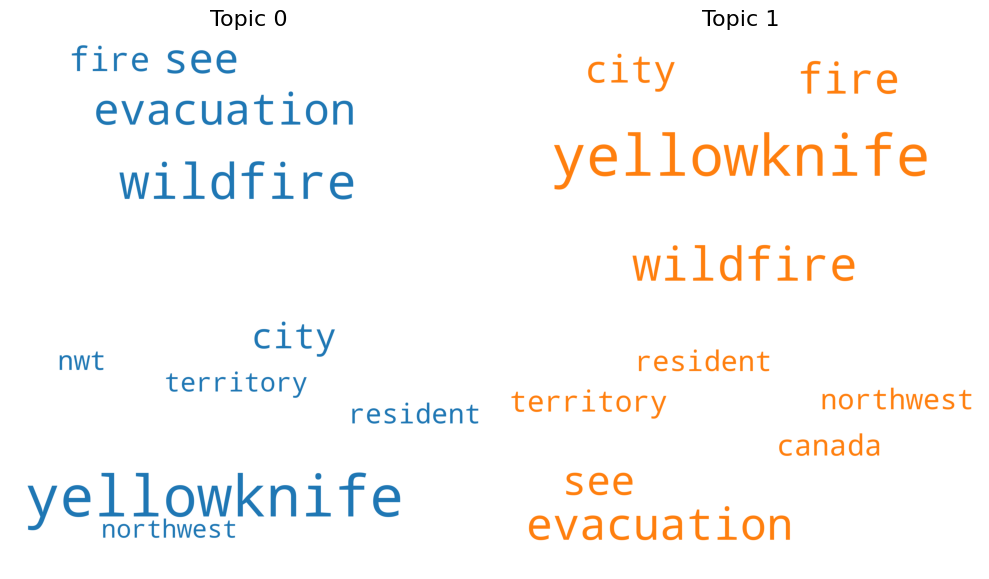

In [97]:
fig, axes = plt. subplots(1, 2, figsize=(10,10), sharex=True, sharey=True)
for i, ax in enumerate(axes.flatten()):
  fig.add_subplot(ax)
  topic_words = dict(topics[i][1])
  cloud.generate_from_frequencies(topic_words, max_font_size=300)
  plt.gca().imshow(cloud)
  plt.gca().set_title('Topic ' + str(i), fontdict=dict(size=16))
  plt.gca().axis('off')
plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
plt.margins(x=0, y=0)
plt.tight_layout()
plt.show